如果您感兴趣的语言没有可用的语言模型，或者您的语料库与您的语言模型训练所用的语料库非常不同，您很可能希望使用适合您的数据的分词器从头开始重新训练模型。这将需要在您的数据集上训练一个新的分词器。

In [1]:
!pip install datasets evaluate transformers[sentencepiece]
!apt install git-lfs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.2 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
Reading package lists... Done
Building dependency tree... Done
Reading state informat

In [ ]:
!git config --global user.email "you@example.com"
!git config --global user.name "Your Name"

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [2]:
#导入CodeSearchNet挑战赛数据集，该数据集包含来自GitHub上多种编程语言的开源库的数百万个函数。
#在这里，我们将加载该数据集的Python部分
from datasets import load_dataset

raw_datasets = load_dataset("code_search_net", "python")

README.md:   0%|          | 0.00/12.9k [00:00<?, ?B/s]

code_search_net.py:   0%|          | 0.00/8.44k [00:00<?, ?B/s]

The repository for code_search_net contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/code_search_net.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


python.zip:   0%|          | 0.00/941M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/412178 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/22176 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/23107 [00:00<?, ? examples/s]

In [3]:
#have a look at the dataset
raw_datasets["train"]

Dataset({
    features: ['repository_name', 'func_path_in_repository', 'func_name', 'whole_func_string', 'language', 'func_code_string', 'func_code_tokens', 'func_documentation_string', 'func_documentation_tokens', 'split_name', 'func_code_url'],
    num_rows: 412178
})

In [4]:
#我们只使用Whole_func_string列训练我们的分词器。
#先看个例子
print(raw_datasets["train"][123456]["whole_func_string"])

def has_elem(elem_ref):
    """
    Has element?
    :param elem_ref:
    :return:
    """
    if not is_elem_ref(elem_ref):
        return False
    elif elem_ref[0] == ElemRefObj:
        return hasattr(elem_ref[1], elem_ref[2])
    elif elem_ref[0] == ElemRefArr:
        return elem_ref[2] in elem_ref[1]


我们需要做的第一件事是将数据集转换为文本列表的迭代器。

这样就可以批次处理文本，而不是逐个处理单个文本：数据集不会把所有内容加载到RAM中，而是将数据集的元素存储在磁盘上。

Python 生成器（Generator）是一种用于创建迭代器的工具，可以通过惰性求值（lazy evaluation）来逐个生成数据，而不是一次性将所有数据存储在内存中，从而提高内存效率。

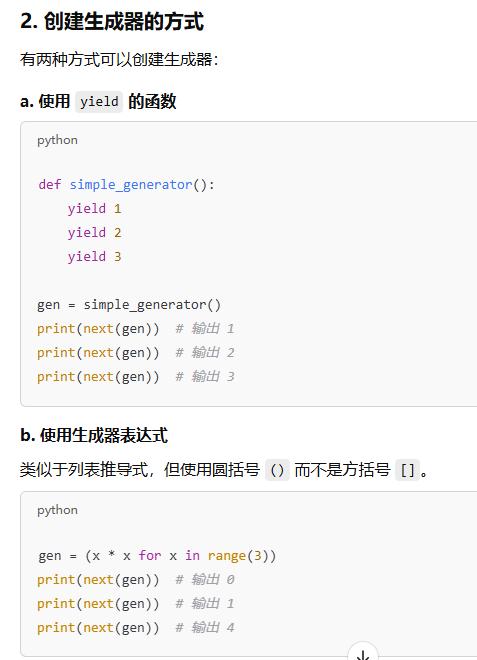

In [5]:
training_corpus = (
    raw_datasets["train"][i : i + 1000]["whole_func_string"]
    for i in range(0, len(raw_datasets["train"]), 1000)
)

这段代码不会获取数据集的任何元素，它只是创建一个可以在Python for循环中使用的对象。

只有当您需要文本时，才会加载文本，并且一次只会加载1000个文本。这样即使正在处理巨大的数据集，也不会耗尽所有内存。

生成器对象的问题是它只能使用一次。我们来看一下如果使用两次会发生什么情况：

In [6]:
gen = (i for i in range(10))
print(list(gen))
print(list(gen))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[]


因为只能使用一次，所以我们定义一个生成器函数而不是一个生成器

In [7]:
def get_training_corpus():
  return (
      raw_datasets["train"][i : i + 1000]["whole_func_string"]
      for i in range(0, len(raw_datasets["train"]), 1000)
  )

training_corpus = get_training_corpus()

In [8]:
#或者我们也可以在方法中使用for循环来定义

def get_training_corpus():
  dataset = raw_datasets["train"]
  for start_idx in range(0,len(dataset), 1000):
    samples = dataset[start_idx : start_idx + 1000]
    yield samples["whole_func_string"]

现在既然我们已经准备好批量形式迭代的语料库了，可以开始训练一个新的tokenizer了。

首先第一步是导入与我们的模型匹配的tokenizer。

因为尽管我们要训练一个新的tokenizer，但是避免完全的从头开始是一个好主意。

我们的新tokenizer与旧的相比，唯一的不同是词汇，这将由我们语料库上的训练决定。

In [10]:
from transformers import AutoTokenizer

old_tokenizer = AutoTokenizer.from_pretrained("gpt2")

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [11]:
#首先看一下这个tokenizer会如何处理实例函数
example = '''def add_numbers(a, b):
    """Add the two numbers `a` and `b`."""
    return a + b'''

tokens = old_tokenizer.tokenize(example)
tokens

['def',
 'Ġadd',
 '_',
 'n',
 'umbers',
 '(',
 'a',
 ',',
 'Ġb',
 '):',
 'Ċ',
 'Ġ',
 'Ġ',
 'Ġ',
 'Ġ"""',
 'Add',
 'Ġthe',
 'Ġtwo',
 'Ġnumbers',
 'Ġ`',
 'a',
 '`',
 'Ġand',
 'Ġ`',
 'b',
 '`',
 '."',
 '""',
 'Ċ',
 'Ġ',
 'Ġ',
 'Ġ',
 'Ġreturn',
 'Ġa',
 'Ġ+',
 'Ġb']

我们可以看到，该分词结果并不是高效的：

1.该tokenizer有一些特殊符号Ċ，Ġ分别表示换行和空格符。

2.tokenizer为表示缩进的每一个空格返回单独的token，但是在代码中四个或者八个空格的缩进是非常常见的。

3.将函数名称分割的很奇怪。

4.不习惯看到带有_字符的单词

因此，让我们来训练一个新的tokenizer来解决这些问题。

In [12]:
#使用old_tokenizer对training_corpus进行训练，生成新的词汇表，将词汇表大小设置为52000
tokenizer = old_tokenizer.train_new_from_iterator(training_corpus, 52000)

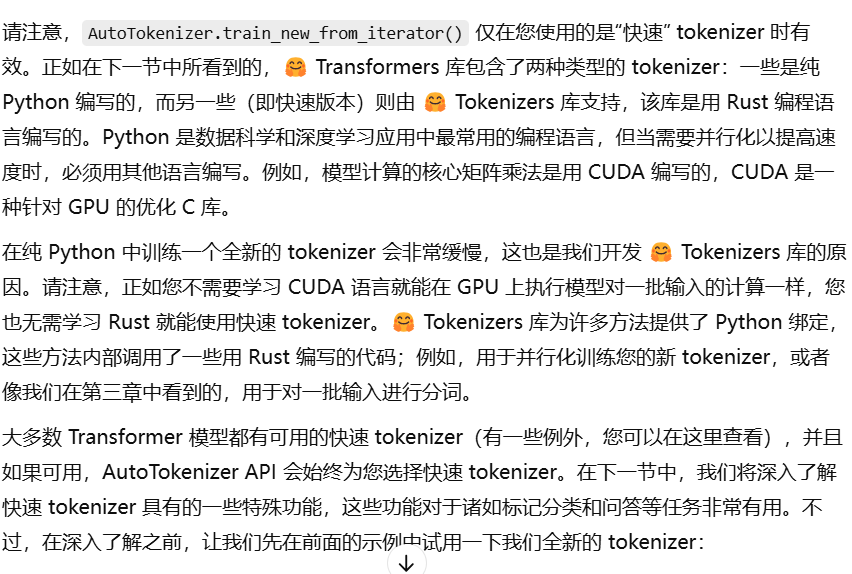

In [13]:
tokens = tokenizer.tokenize(example)
tokens

['def',
 'Ġadd',
 '_',
 'numbers',
 '(',
 'a',
 ',',
 'Ġb',
 '):',
 'ĊĠĠĠ',
 'Ġ"""',
 'Add',
 'Ġthe',
 'Ġtwo',
 'Ġnumbers',
 'Ġ`',
 'a',
 '`',
 'Ġand',
 'Ġ`',
 'b',
 '`."""',
 'ĊĠĠĠ',
 'Ġreturn',
 'Ġa',
 'Ġ+',
 'Ġb']

在这里，我们再次看到表示空格和换行符的特殊符号 Ġ 和 Ċ，但我们还可以看到我们的分词器学习了一些针对 Python 函数语料库高度特定的标记：例如，有一个 ĊĠĠĠ 标记表示缩进，以及一个 Ġ""" 标记，表示启动文档字符串的三个引号。标记生成器还正确地在 _ 上分割函数名称。这是一个相当紧凑的表示；相比之下，使用同一个例子的简单英语分词器会给我们一个更长的句子：

In [14]:
print(len(tokens))
print(len(old_tokenizer.tokenize(example)))

27
36


In [15]:
#看一下另一个例子
example = """class LinearLayer():
    def __init__(self, input_size, output_size):
        self.weight = torch.randn(input_size, output_size)
        self.bias = torch.zeros(output_size)

    def __call__(self, x):
        return x @ self.weights + self.bias
    """
tokenizer.tokenize(example)

['class',
 'ĠLinear',
 'Layer',
 '():',
 'ĊĠĠĠ',
 'Ġdef',
 'Ġ__',
 'init',
 '__(',
 'self',
 ',',
 'Ġinput',
 '_',
 'size',
 ',',
 'Ġoutput',
 '_',
 'size',
 '):',
 'ĊĠĠĠĠĠĠĠ',
 'Ġself',
 '.',
 'weight',
 'Ġ=',
 'Ġtorch',
 '.',
 'randn',
 '(',
 'input',
 '_',
 'size',
 ',',
 'Ġoutput',
 '_',
 'size',
 ')',
 'ĊĠĠĠĠĠĠĠ',
 'Ġself',
 '.',
 'bias',
 'Ġ=',
 'Ġtorch',
 '.',
 'zeros',
 '(',
 'output',
 '_',
 'size',
 ')',
 'ĊĊĠĠĠ',
 'Ġdef',
 'Ġ__',
 'call',
 '__(',
 'self',
 ',',
 'Ġx',
 '):',
 'ĊĠĠĠĠĠĠĠ',
 'Ġreturn',
 'Ġx',
 'Ġ@',
 'Ġself',
 '.',
 'weights',
 'Ġ+',
 'Ġself',
 '.',
 'bias',
 'ĊĠĠĠĠ']

除了对应于缩进的标记之外，这里我们还可以看到用于双缩进的标记：ĊĠĠĠĠĠĠĠ。像 class、init、call、self 和 return 这样的特殊 Python 单词都被标记为一个标记，我们可以看到这一点以及 _ 和 _ 上的拆分。分词器甚至可以正确地分割驼峰式名称：LinearLayer 被分词为 ["ĠLinear", "Layer"]

**Saving the Tokenizer**

In [ ]:
#保存下来新的tokenizer，以便以后使用
tokenizer.save_pretrained("code-search-net-tokenizer")

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
tokenizer.push_to_hub("code-search-net-tokenizer")

In [ ]:
#在您的namespace中创建名为code-search-net-tokenizer的新仓库，其中包含tokenizer文件。
#然后，你可以用from_pretrained()方法从任何地方加载tokenizer

tokenizer = AutoTokenizer.from_pretrained("huggingface-course/code-search-net-tokenizer")